<a href="https://colab.research.google.com/github/efsiul/fruit_sorter_project/blob/master/Luis_Cadavid_Johana_Rios_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development of a Fresh Fruit Detection Model from Rotten Fruits Using Deep Learning

You will train a new model that is able to recognize fresh and rotten fruit. You will need to get the model to a validation accuracy of `92%` in order to pass the assessment, though we challenge you to do even better if you can. We suggest using some combination of transfer learning, data augmentation, and fine tuning. Once you have trained the model to be at least 92% accurate on the validation dataset, save your model, and then assess its accuracy. Let's get started!

## The Dataset

In this exercise, you will train a model to recognize fresh and rotten fruits. The dataset comes from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification), a great place to go if you're interested in starting a project after this class. The dataset structure is in the `data/fruits` folder. There are 6 categories of fruits: fresh apples, fresh oranges, fresh bananas, rotten apples, rotten oranges, and rotten bananas. This will mean that your model will require an output layer of 6 neurons to do the categorization successfully. You'll also need to compile the model with `categorical_crossentropy`, as we have more than two categories.

<img src="./images/fruits.png" style="width: 400px;">
# revisar la ubicacion de la imagen para que se vea!

## Load ImageNet Base Model

We encourage you to start with a model pretrained on ImageNet. Load the model with the correct weights, set an input shape, and choose to remove the last layers of the model. Remember that images have three dimensions: a height, and width, and a number of channels. Because these pictures are in color, there will be three channels for red, green, and blue. We've filled in the input shape for you. This cannot be changed or the assessment will fail.

In [ ]:
%pip install tensorflow

In [ ]:
tpu_info = !nvidia-smi
tpu_info = '\n'.join(tpu_info)
if tpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(tpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
%pip install tensorflow-tpu
%pip install cudatoolkit

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('TPU')))

Num GPUs Available:  8


In [ ]:
tf.config.set_visible_devices

<function tensorflow.python.framework.config.set_visible_devices(devices, device_type=None)>

In [ ]:
tf.config.set_visible_devices

## Freeze Base Model

Next, we suggest freezing the base model, This is done so that all the learning from the ImageNet dataset does not get destroyed in the initial training.

In [ ]:
# Freeze base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

## Add Layers to Model

Now it's time to add layers to the pretrained model. Pay close attention to the last dense layer and make sure it has the correct number of neurons to classify the different types of fruit.

In [ ]:
# Create inputs with correct shape
inputs = Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer or flatten layer
x = layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = layers.Dense(6, activation='softmax')(x)

# Combine inputs and outputs to create model
model = models.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14717766 (56.14 MB)
Trainable params: 3078 (12.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


## Compile Model

Now it's time to compile the model with loss and metrics options. Remember that we're training on a number of different categories, rather than a binary classification problem.

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## Augment the Data

If you'd like, try to augment the data to improve the dataset. There is also documentation for the [Keras ImageDataGenerator class](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). This step is optional, but it may be helpful to get to 92% accuracy.

In [ ]:
datagen_train = ImageDataGenerator(samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)

datagen_valid = ImageDataGenerator(samplewise_center=True)


## Load Dataset

Now it's time to load the train and validation datasets. Pick the right folders, as well as the right `target_size` of the images (it needs to match the height and width input of the model you've created).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/train',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    '/content/drive/MyDrive/Udea/Simulación/test',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Ensure the order of images is the same for predictions and labels
)

Found 9833 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


## Train the Model

Time to train the model! Pass the `train` and `valid` iterators into the `fit` function, as well as setting the desired number of epochs.

In [ ]:
model.fit(train_it,
          validation_data=valid_it,
          steps_per_epoch= int(train_it.samples/train_it.batch_size),
          validation_steps=int(valid_it.samples/valid_it.batch_size),
          epochs=20)

Epoch 1/20
307/307 [==============================] - 287s 935ms/step - loss: 0.2619 - categorical_accuracy: 0.9082 - val_loss: 0.2142 - val_categorical_accuracy: 0.9297
Epoch 2/20
307/307 [==============================] - 287s 933ms/step - loss: 0.1566 - categorical_accuracy: 0.9436 - val_loss: 0.1096 - val_categorical_accuracy: 0.9654
Epoch 3/20
307/307 [==============================] - 286s 931ms/step - loss: 0.1066 - categorical_accuracy: 0.9617 - val_loss: 0.1248 - val_categorical_accuracy: 0.9643
Epoch 4/20
307/307 [==============================] - 287s 933ms/step - loss: 0.0909 - categorical_accuracy: 0.9704 - val_loss: 0.0989 - val_categorical_accuracy: 0.9661
Epoch 5/20
307/307 [==============================] - 290s 945ms/step - loss: 0.0759 - categorical_accuracy: 0.9723 - val_loss: 0.0948 - val_categorical_accuracy: 0.9680
Epoch 6/20
307/307 [==============================] - 290s 944ms/step - loss: 0.0743 - categorical_accuracy: 0.9743 - val_loss: 0.0722 - val_categoric

___

# Evaluate the Model

Hopefully, you now have a model that has a validation accuracy of 92% or higher. If not, you may want to go back and either run more epochs of training, or adjust your data augmentation.

Once you are satisfied with the validation accuracy, evaluate the model by executing the following cell. The evaluate function will return a tuple, where the first value is your loss, and the second value is your accuracy. To pass, the model will need have an accuracy value of `92% or higher`.

In [ ]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

84/84 [==============================] - 52s 615ms/step - loss: 0.0636 - categorical_accuracy: 0.9826


[0.06363651901483536, 0.9825797080993652]

# Confusion Matrix

In [ ]:
%pip install matplotlib seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


In [ ]:
# Generate predictions
valid_it.reset()  # Reset the generator before predicting
y_pred = model.predict(valid_it, steps=valid_it.samples / valid_it.batch_size + 1, verbose=1)
y_true = valid_it.classes

85/85 [============================>.] - ETA: 0s

85/85 [==============================] - 52s 608ms/step


In [ ]:
# Ensure y_pred covers all samples
if y_pred.shape[0] > y_true.shape[0]:
    y_pred = y_pred[:y_true.shape[0]]
elif y_pred.shape[0] < y_true.shape[0]:
    y_true = y_true[:y_pred.shape[0]]


In [ ]:
# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)


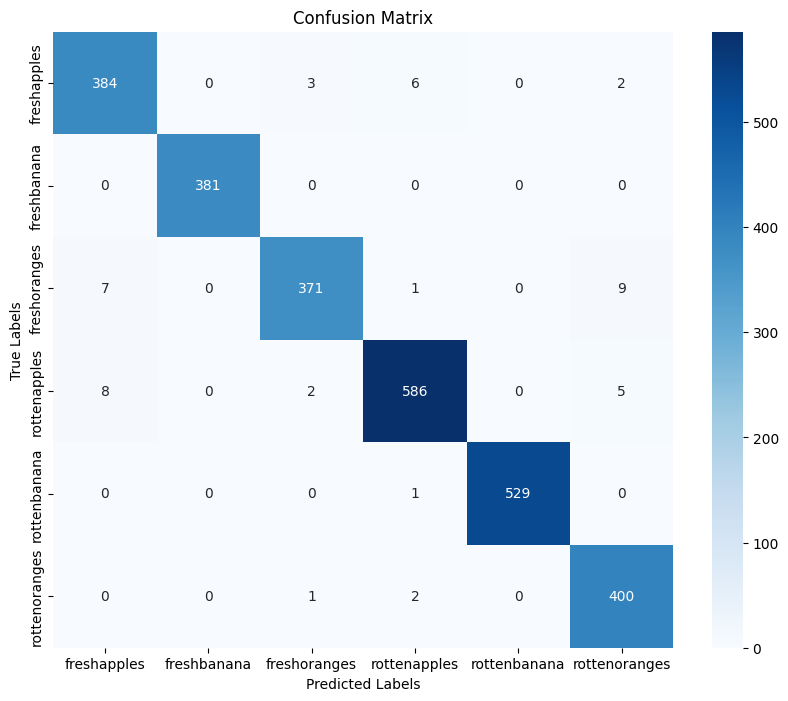

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_it.class_indices, yticklabels=valid_it.class_indices)
plt.title('VGG16 Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Analyzing some metrics:

In [ ]:
# Calculate precision, recall, and F1 score
class_report = classification_report(y_true, y_pred_classes, target_names=valid_it.class_indices.keys())
print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

  freshapples       0.96      0.97      0.97       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       0.98      0.96      0.97       388
 rottenapples       0.98      0.98      0.98       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.96      0.99      0.98       403

     accuracy                           0.98      2698
    macro avg       0.98      0.98      0.98      2698
 weighted avg       0.98      0.98      0.98      2698



# Download PKL File of Model

In [ ]:
import pickle
from google.colab import files

# Guarda el modelo entrenado en un archivo .pkl
with open('modelo_entrenado.pkl', 'wb') as f:
    pickle.dump(model, f)

# Descarga el archivo .pkl desde Google Colab
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the Assessment

To assess your model run the following two cells.

**NOTE:** `run_assessment` assumes your model is named `model` and your validation data iterator is called `valid_it`. If for any reason you have modified these variable names, please update the names of the arguments passed to `run_assessment`.

In [ ]:
run_assessment(model, valid_it)

---